In [2]:
import detprocess as dp
import numpy as np
import pandas as pd
from pprint import pprint
import astropy
import vaex as vx
from matplotlib import pyplot as plt
from detanalysis import Analyzer, Semiautocut, ScatterPlotter 
import matplotlib as mpl
import qetpy
import scipy
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
from scipy import stats, optimize, interpolate
import scipy.optimize as opt
from scipy.special import erf
import math
from astropy import units as U
import detanalysis.func as cut
mpl.rcParams['figure.figsize'] = [10, 6.5]
from pytesdaq.io.hdf5 import H5Reader,H5Writer

import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
fs = 1.25e6 #sample_rate [hz]
tracelength = 10e-3 #[s]
channels = ['IrPtTESSmallV2', 'IrPtTESBigV2', 'CPDv21Al2O3']

In [5]:
basedir = '/home/maggie_reed/analysis/run35/continuous/figs/'

In [3]:
#evening 3 hour set
myanalyzer = Analyzer('/sdata2/runs/run35/processed/continuous_I2_D20231114_T204431/feature_I2_D20231120_T102722',series=None)

In [15]:
myanalyzer.add_feature((myanalyzer.df.event_time - myanalyzer.df.event_time.min())/60, 'timesincestart',overwrite=True)
myanalyzer.add_feature((myanalyzer.df.tes_bias_CPDv21Al2O3*myanalyzer.df.baseline_CPDv21Al2O3), 'power_CPDv21Al2O3',overwrite=True)
myanalyzer.add_feature((myanalyzer.df.tes_bias_IrPtTESSmallV2*myanalyzer.df.baseline_IrPtTESSmallV2), 'power_IrPtTESSmallV2',overwrite=True)
myanalyzer.add_feature((myanalyzer.df.tes_bias_IrPtTESBigV2*myanalyzer.df.baseline_IrPtTESBigV2), 'power_IrPtTESBigV2',overwrite=True)


In [7]:
myanalyzer.df.head()

#,baseline_CPDv21Al2O3,baseline_IrPtTESBigV2,baseline_IrPtTESSmallV2,baseline_end_CPDv21Al2O3,baseline_end_IrPtTESBigV2,baseline_end_IrPtTESSmallV2,data_type,dump_number,event_number,event_time,fridge_run_number,fridge_run_start_time,group_name,group_start_time,integral_CPDv21Al2O3,integral_IrPtTESBigV2,integral_IrPtTESSmallV2,maximum_CPDv21Al2O3,maximum_IrPtTESBigV2,maximum_IrPtTESSmallV2,minimum_CPDv21Al2O3,minimum_IrPtTESBigV2,minimum_IrPtTESSmallV2,output_gain_CPDv21Al2O3,output_gain_IrPtTESBigV2,output_gain_IrPtTESSmallV2,processing_id,series_number,series_start_time,tes_bias_CPDv21Al2O3,tes_bias_IrPtTESBigV2,tes_bias_IrPtTESSmallV2,trigger_index,trigger_prod_group_name,trigger_prod_id,trigger_time,trigger_type,index,timesincestart
0,-1.297e-07,-2.15528e-07,-2.66919e-08,-1.29171e-07,-2.15002e-07,-2.6258e-08,1,1,100001,1.70003e+09,35,175431,continuous_I2_D20231114_T204431,7159,-6.77653e-11,-1.09296e-10,-1.26082e-11,-7.3164e-08,-1.49445e-07,4.52694e-08,-1.70171e-07,-2.63914e-07,-7.92001e-08,50,50,50,nan,2.20231e+14,14,3.22698e-05,4.98521e-05,1.07804e-05,938530,trigger_I2_D20231120_T102708,1,0.750824,3,0,116.1
1,-6.02785e-08,-2.15485e-07,-2.68445e-08,-6.05371e-08,-2.14998e-07,-2.60917e-08,1,1,100001,1.70003e+09,35,175433,continuous_I2_D20231114_T204431,7161,-6.49361e-11,-1.09838e-10,-1.38433e-11,1.55746e-06,-1.47445e-07,4.92685e-08,-1.58171e-07,-2.71662e-07,-8.31991e-08,50,50,50,nan,2.20231e+14,16,3.22698e-05,4.98521e-05,1.07804e-05,3.65129e+06,trigger_I2_D20231120_T102708,2,2.92103,3,1,116.133
2,-1.29284e-07,-2.15159e-07,-2.63597e-08,-1.28905e-07,-2.15443e-07,-2.65042e-08,1,1,100002,1.70003e+09,35,175445,continuous_I2_D20231114_T204431,7173,-6.68798e-11,-1.09814e-10,-1.38032e-11,-7.3664e-08,-1.44696e-07,5.20178e-08,-1.66671e-07,-2.77411e-07,-9.46963e-08,50,50,50,nan,2.20231e+14,28,3.22698e-05,4.98521e-05,1.07804e-05,6.62154e+06,trigger_I2_D20231120_T102708,3,5.29723,3,2,116.333
3,-1.13546e-07,-2.15533e-07,-2.7091e-08,-1.22414e-07,-2.14771e-07,-2.63507e-08,1,1,100002,1.70003e+09,35,175447,continuous_I2_D20231114_T204431,7175,-5.96256e-11,-1.09196e-10,-1.30256e-11,5.90962e-08,-1.46195e-07,4.65191e-08,-1.5442e-07,-2.70913e-07,-7.74505e-08,50,50,50,nan,2.20231e+14,30,3.22698e-05,4.98521e-05,1.07804e-05,9.1588e+06,trigger_I2_D20231120_T102708,4,7.32704,3,3,116.367
4,-6.56503e-08,-2.15177e-07,-2.66752e-08,4.38348e-09,-2.15583e-07,-2.70035e-08,1,1,100003,1.70003e+09,35,175452,continuous_I2_D20231114_T204431,7180,7.89314e-10,-1.09486e-10,-1.39722e-11,1.59622e-06,-1.47945e-07,4.52694e-08,-1.13667e-07,-2.72662e-07,-9.34466e-08,50,50,50,nan,2.20231e+14,35,3.22698e-05,4.98521e-05,1.07804e-05,1.99708e+06,trigger_I2_D20231120_T102708,5,1.59766,3,4,116.45
5,-1.08244e-07,-2.1554e-07,-2.67823e-08,-1.10313e-07,-2.14922e-07,-2.6571e-08,1,1,100003,1.70003e+09,35,175453,continuous_I2_D20231114_T204431,7181,-5.70957e-11,-1.0959e-10,-1.39953e-11,-4.26616e-08,-1.49944e-07,4.40197e-08,-1.4967e-07,-2.72162e-07,-8.71981e-08,50,50,50,nan,2.20231e+14,36,3.22698e-05,4.98521e-05,1.07804e-05,3.16619e+06,trigger_I2_D20231120_T102708,6,2.53295,3,5,116.467
6,-1.26955e-07,-2.14471e-07,-2.6914e-08,-1.28486e-07,-2.13648e-07,-2.6051e-08,1,1,100004,1.70003e+09,35,175462,continuous_I2_D20231114_T204431,7190,-7.02695e-11,-1.08774e-10,-1.34156e-11,-7.3414e-08,-1.47695e-07,3.85211e-08,-1.69921e-07,-2.73412e-07,-8.64483e-08,50,50,50,nan,2.20231e+14,45,3.22698e-05,4.98521e-05,1.07804e-05,2.51822e+06,trigger_I2_D20231120_T102708,7,2.01458,3,6,116.617
7,-1.21586e-07,-2.13945e-07,-2.65446e-08,-1.24352e-07,-2.1405e-07,-2.66358e-08,1,1,100004,1.70003e+09,35,175467,continuous_I2_D20231114_T204431,7195,-6.44491e-11,-1.08453e-10,-1.37988e-11,-6.69135e-08,-1.46445e-07,4.00207e-08,-1.63921e-07,-2.68913e-07,-8.19494e-08,50,50,50,nan,2.20231e+14,50,3.22698e-05,4.98521e-05,1.07804e-05,8.54898e+06,trigger_I2_D20231120_T102708,8,6.83919,3,7,116.7
8,-1.14716e-07,-2.13677e-07,-2.60338e-08,-6.66167e-08,-2.14561e-07,-2.70872e-08,1,1,100005,1.70003e+09,35,175474,continuous_I2_D20231114_T2

# Baseline, Afternoon Set

## IrPt Small

TypeError: can't multiply sequence by non-int of type 'float'

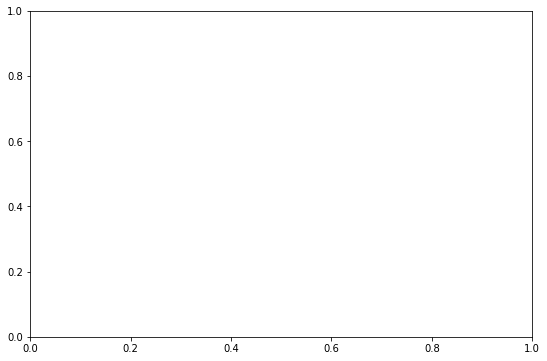

In [16]:
fig,ax  = myanalyzer.heatmap('timesincestart',
                             'power_IrPtTESSmallV2',
                            # ylimits = [-1.44e-6, -1.4e-6],
                             xlabel='Time Since Run Start [m]', ylabel='Baseline of baseline_IrPtTESSmallV2',
                             title='IrPtTESSmallV2 Baseline vs Time: no cuts',)
fig.tight_layout()
'''
fig.savefig(
    basedir+'/25pcright_blvt_nc.png',
    dpi=500,
    facecolor='none',
)
#''';

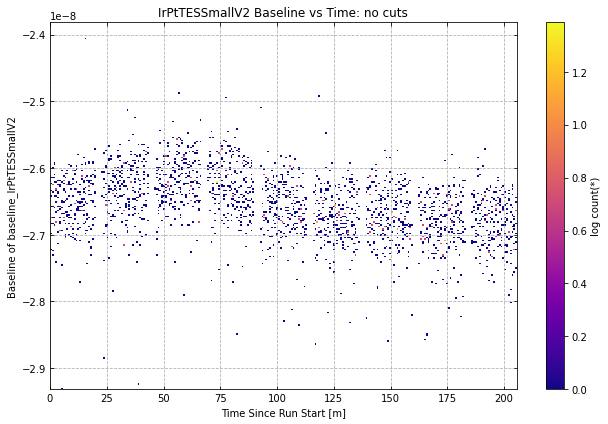

In [9]:
fig,ax  = myanalyzer.heatmap('timesincestart',
                             'baseline_IrPtTESSmallV2',
                            # ylimits = [-1.44e-6, -1.4e-6],
                             xlabel='Time Since Run Start [m]', ylabel='Baseline of baseline_IrPtTESSmallV2',
                             title='IrPtTESSmallV2 Baseline vs Time: no cuts',)
fig.tight_layout()
'''
fig.savefig(
    basedir+'/25pcright_blvt_nc.png',
    dpi=500,
    facecolor='none',
)
#''';

## baseline_IrPtTESBigV2

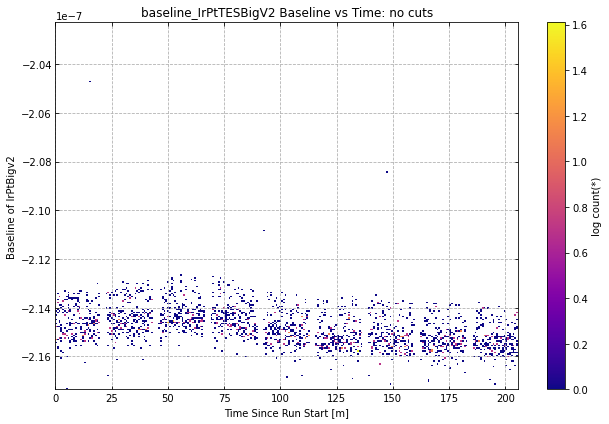

In [10]:
fig,ax  = myanalyzer.heatmap('timesincestart',
                             'baseline_IrPtTESBigV2',
                            # ylimits = [-1.44e-6, -1.4e-6],
                             xlabel='Time Since Run Start [m]', ylabel='Baseline of IrPtBigv2',
                             title='baseline_IrPtTESBigV2 Baseline vs Time: no cuts',)
fig.tight_layout()
'''
fig.savefig(
    basedir+'/25pcleft_blvt_nc.png',
    dpi=500,
    facecolor='none',
)
#''';

## baseline_CPDv21Al2O3

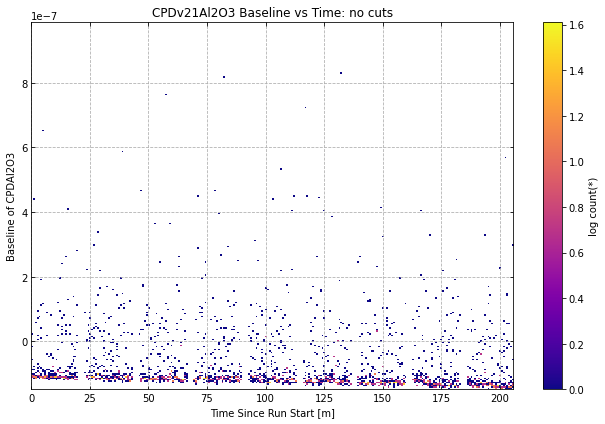

In [11]:
fig,ax  = myanalyzer.heatmap('timesincestart',
                             'baseline_CPDv21Al2O3',
                            # ylimits = [-1.44e-6, -1.4e-6],
                             xlabel='Time Since Run Start [m]', ylabel='Baseline of CPDAl2O3',
                             title='CPDv21Al2O3 Baseline vs Time: no cuts',)
fig.tight_layout()
'''
fig.savefig(
    basedir+'/1pc_blvt_nc.png',
    dpi=500,
    facecolor='none',
)
#''';

## Melange4pc1ch

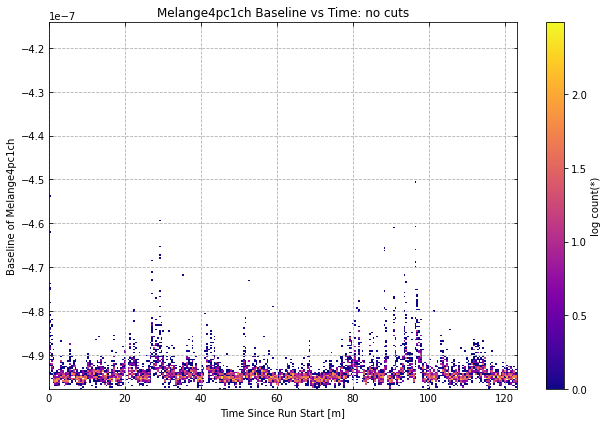

In [14]:
fig,ax  = myanalyzer.heatmap('timesincestart',
                             'baseline_Melange4pc1ch',
                            # ylimits = [-1.44e-6, -1.4e-6],
                             xlabel='Time Since Run Start [m]', ylabel='Baseline of Melange4pc1ch',
                             title='Melange4pc1ch Baseline vs Time: no cuts',)
fig.tight_layout()
'''
fig.savefig(
    basedir+'/4pc_blvt_nc.png',
    dpi=500,
    facecolor='none',
)
#''';

# Baseline, Evening Set 

## Melange025pcRight

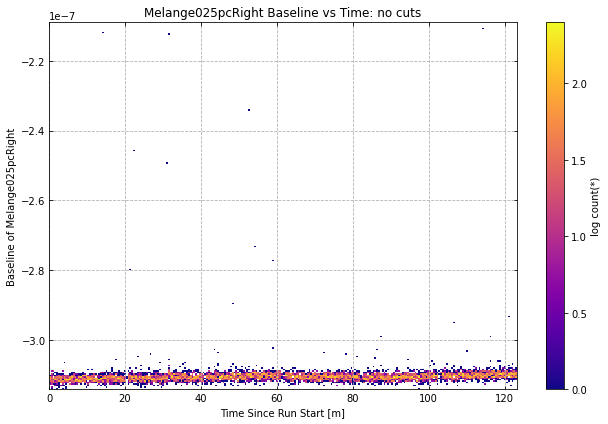

In [19]:
fig,ax  = myanalyzer2.heatmap('timesincestart',
                             'baseline_Melange025pcRight',
                            # ylimits = [-1.44e-6, -1.4e-6],
                             xlabel='Time Since Run Start [m]', ylabel='Baseline of Melange025pcRight',
                             title='Melange025pcRight Baseline vs Time: no cuts',)
fig.tight_layout()
'''
fig.savefig(
    basedir+'/evening_25pcright_blvt_nc.png',
    dpi=500,
    facecolor='none',
)
#''';

## Melange025pcLeft

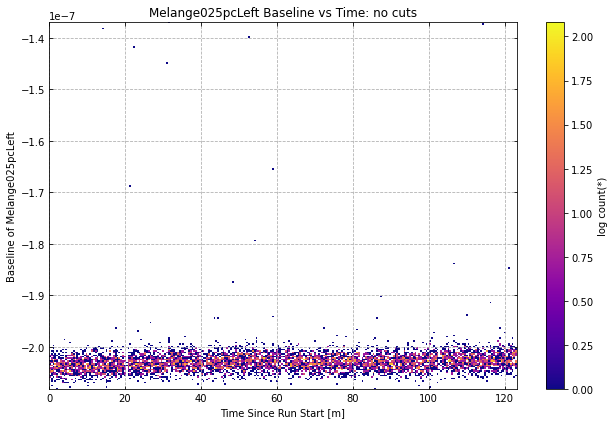

In [21]:
fig,ax  = myanalyzer2.heatmap('timesincestart',
                             'baseline_Melange025pcLeft',
                            # ylimits = [-1.44e-6, -1.4e-6],
                             xlabel='Time Since Run Start [m]', ylabel='Baseline of Melange025pcLeft',
                             title='Melange025pcLeft Baseline vs Time: no cuts',)
fig.tight_layout()
'''
fig.savefig(
    basedir+'/evening_25pcleft_blvt_nc.png',
    dpi=500,
    facecolor='none',
)
#''';

## Melange1pc1ch

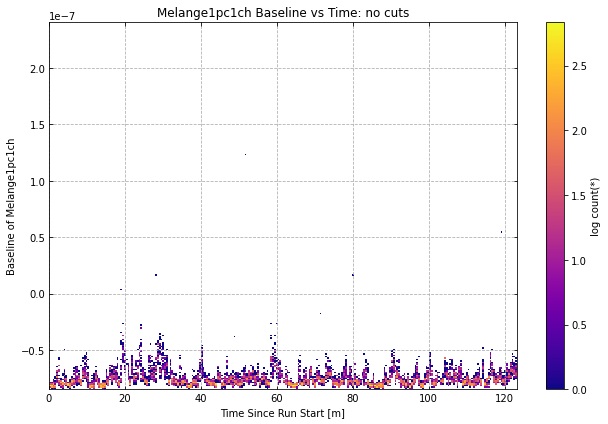

In [23]:
fig,ax  = myanalyzer2.heatmap('timesincestart',
                             'baseline_Melange1pc1ch',
                            # ylimits = [-1.44e-6, -1.4e-6],
                             xlabel='Time Since Run Start [m]', ylabel='Baseline of Melange1pc1ch',
                             title='Melange1pc1ch Baseline vs Time: no cuts',)
fig.tight_layout()
'''
fig.savefig(
    basedir+'/evening_1pc_blvt_nc.png',
    dpi=500,
    facecolor='none',
)
#''';

## Melange4pc1ch

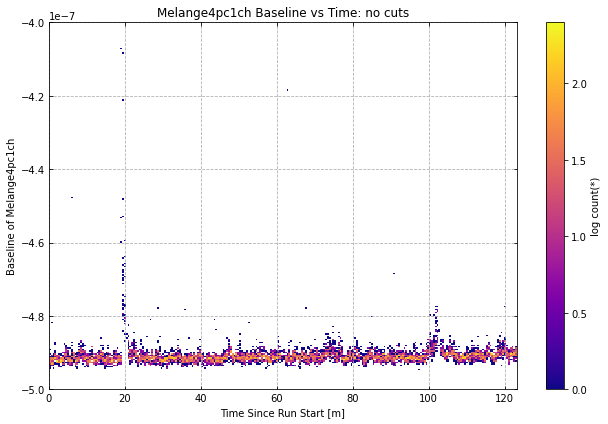

In [29]:
fig,ax  = myanalyzer2.heatmap('timesincestart',
                             'baseline_Melange4pc1ch',
                             ylimits = [-5e-7, -4e-7],
                             xlabel='Time Since Run Start [m]', ylabel='Baseline of Melange4pc1ch',
                             title='Melange4pc1ch Baseline vs Time: no cuts',)
fig.tight_layout()
'''
fig.savefig(
    basedir+'/evening_4pc_blvt_nc.png',
    dpi=500,
    facecolor='none',
)
#''';